# Predictive analysis of Bank Marketing

#### Problem Statement
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

#### What to achieve?
The classification goal is to predict if the client will subscribe a term deposit (variable y).

#### Data Contains information in following format:

### Categorical Variable :

* Marital - (Married , Single , Divorced)",
* Job - (Management,BlueCollar,Technician,entrepreneur,retired,admin.,services,selfemployed,housemaid,student,unemployed,unknown)
* Contact - (Telephone,Cellular,Unknown)
* Education - (Primary,Secondary,Tertiary,Unknown)
* Month - (Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec)
* Poutcome - (Success,Failure,Other,Unknown)
* Housing - (Yes/No)
* Loan - (Yes/No)
* Default - (Yes/No)

### Numerical Variable:

* Age
* Balance
* Day
* Duration
* Campaign
* Pdays
* Previous

#### Class
* deposit - (Yes/No)

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#creating HDR slices
from sklearn.neighbors import KernelDensity
import arviz as az
from sklearn import metrics

# data synthesizing
from collections import Counter
from ctgan import CTGANSynthesizer
from ctgan import load_demo

## Hyper-parameters

In [2]:
# splitting dataset
val_size = .15
test_size = .15
train_size = 1 - val_size - test_size

# creating hdr slices with kde
bw=.35 # bandwith
cf=-3 # cuttoff

# importance of slices
sig = .02
min_support = .05

# synthesizing data with ADASYN
gen_p = .5
num_problem_slices = 10

## Exploring dataset

In [3]:
#Importing and displaying data
data = pd.read_csv("bank-full.csv", delimiter=";",header='infer')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
#4521 rows and 17 features
data.shape

(45211, 17)

In [5]:
#datatypes of the columns
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
#Since y is a class variable we will have to convert it into binary format. (Since 2 unique class values)
data.y.replace(('yes', 'no'), (1, 0), inplace=True)

In [7]:
#Spliting data as X -> features and y -> class variable
data_y = pd.DataFrame(data['y'])
data_X = data.drop(['y'], axis=1)
print(data_X.columns)
print(data_y.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
Index(['y'], dtype='object')


## Spliting and manipulating datasets

In [8]:
#Dividing records in training validation and testing sets along with its shape (rows, cols)
X_train, X_test_raw, y_train, y_test = \
train_test_split(data_X, data_y, test_size=test_size, random_state=2, stratify=data_y)

X_train_raw, X_val_raw, y_train, y_val = \
train_test_split(X_train, y_train, test_size=val_size/(val_size+train_size), random_state=2, stratify=y_train)

print (X_train_raw.shape)
print(X_val_raw.shape)
print (X_test_raw.shape)

print (y_train.shape)
print(y_val.shape)
print (y_test.shape)

(31647, 16)
(6782, 16)
(6782, 16)
(31647, 1)
(6782, 1)
(6782, 1)


Since the dtype contains types other than int, float; we need to convert those column values into proper format in order to fit the data in model.

In [9]:
cat_feats = []
for i, col in enumerate(data.dtypes):
    if np.issubdtype(col, np.integer) == False and np.issubdtype(col, np.floating) == False:
        if data.columns[i] == 'y':
            pass
        else:
            cat_feats.append(data.columns[i])

cat_feats

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [10]:
#Converting object type data into numeric type using One-Hot encoding method which is
#majorly used for XGBoost (for better accuracy) [Applicable only for non numeric categorical features]
X_train = pd.get_dummies(X_train_raw, columns=cat_feats)
X_val = pd.get_dummies(X_val_raw, columns=cat_feats)
X_test = pd.get_dummies(X_test_raw, columns=cat_feats)
#pd is instance of pandas. Using get_dummies method we can directly convert any type of data into One-Hot encoded format.

In [11]:
#Checking types of all the columns converted
X_train.dtypes

age                    int64
balance                int64
day                    int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_divorced       uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
default_no             uint8
default_yes            uint8
housing_no             uint8
housing_yes            uint8
loan_no                uint8
loan_yes               uint8
contact_cellular       uint8
contact_telephone      uint8
contact_unknow

In [12]:
#Our New dataframe ready for XGBoost
X_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
34975,37,1517,6,60,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
42984,70,579,11,82,2,181,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12630,40,13,4,178,1,-1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6120,55,150,27,285,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
15077,43,833,17,156,1,-1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Regular Training

In [13]:
#Create an XGB classifier and train it on 70% of the data set.
from sklearn import svm
from xgboost import XGBClassifier
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [14]:
clf.fit(X_train, y_train)

c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
y_pred = clf.predict(X_val)
np.array(y_pred).shape
np.sum(y_pred.reshape([-1,1]) == np.array(y_val)) / len(y_pred)


0.9059274550280153

In [16]:
#classification accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_val, y_pred))

0.9059274550280153


## Training with boost

**Using xgb Library**

In [17]:
import xgboost as xgb
# X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val)

In [18]:
watchlist = [(dtrain, 'train'),(dtest, 'val')]
print(watchlist)

[(<xgboost.core.DMatrix object at 0x0000016879EDCBE0>, 'train'), (<xgboost.core.DMatrix object at 0x0000016879EDCC10>, 'val')]


In [19]:
#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

In [20]:
XGB_Model = xgb.train(params,dtrain,num_rounds)

[19:16:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:16:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
XGB_Model.dump_model('dump.rawBank.txt')

In [22]:
y_predict = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict, 1).reshape([-1,1])
test_acc = np.sum(y_predict_assignment == np.array(y_val)) / len(y_predict)
test_acc

0.9038631672073135

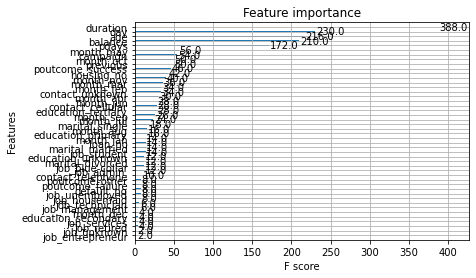

In [23]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(XGB_Model)
pyplot.show()

# Improving Boosted Model

## Creating HDR Slices

In [24]:
def f1(TP,TN,FP,FN):
    return TP/(TP+0.5*(FN+FP)) 

def recall(TP,TN,FP,FN):
    return TP/(TP+FN) 

def precision(TP,TN,FP,FN):
    return TP/(TP+FP) 

def f_beta(TP,TN,FP,FN, beta):
    return ((1+beta*beta)*TP)/((1+beta*beta)*TP+beta*beta*FN+0.5*FP) 

def f_half(TP,TN,FP,FN):
    return f_beta(TP,TN,FP,FN,0.5)

In [25]:
def confusion_metrics(row):
    if row['y'] == 1 and row['y_pred'] == 0:
        val = 'FN'
    elif row['y'] == 0 and row['y_pred'] == 1:
        val = 'FP'
    elif row['y'] == 1:
        val = 'TP'
    else:
        val = 'TN'

    return val

In [26]:
# generalized function for comparing accuracy
def compare_acc(dfx, dfy, y_pred, sl):
    feat = sl[0][0]
    if sl[0][1] is None:
        indexes = np.arange(dfx.index[:][-1])
    elif type(sl[0][1]) == list:
        hdr_min, hdr_max = sl[0][1][0], sl[0][1][1]
        if hdr_min == hdr_max:
            indexes = dfx.index[dfx[feat] == hdr_min]
        else:
            indexes = dfx.index[dfx[feat].between(hdr_min, hdr_max)]
    else:
        indexes = dfx.index[dfx[feat] == sl[0][1]]
    test_acc = np.sum(y_pred == np.array(dfy.values)[:,0]) / len(y_pred)
    sub_acc = np.sum(y_pred[indexes] == np.array(dfy.loc[indexes].values)[:,0]) / len(indexes)

    dif = test_acc - sub_acc
    
    return dif, sub_acc

In [27]:
def compare_f1(dfx, y, y_pred , sl):
    feat = sl[0][0]
    
    val_total_f1 = metrics.f1_score(y, y_pred)
    
    main = pd.DataFrame()
    main[feat] = dfx[feat].copy()

    main['y_pred'] = y_pred
    main['y'] = y
    
    main['metrics'] = main.apply(confusion_metrics, axis=1)

    if type(sl[0][1]) == list:
        left = sl[0][1][0]
        right = sl[0][1][1]

        indexes = dfx.index[dfx[feat].between(left, right)]
        new_dfx = main.loc[indexes]
        new_y = y.loc[indexes]
        new_y_pred = y_pred[indexes]
        
    else:
        val = sl[0][1]
        
        indexes = dfx.index[dfx[feat] == val]
        new_dfx = main.loc[indexes]
        new_y = y.loc[indexes]
        new_y_pred = y_pred[indexes]
    
    TP = new_dfx[feat].where(new_dfx.metrics == 'TP').count()
    TN = new_dfx[feat].where(new_dfx.metrics == 'TN').count()
    FP = new_dfx[feat].where(new_dfx.metrics == 'FP').count()
    FN = new_dfx[feat].where(new_dfx.metrics == 'FN').count()
    if FP == 0 and FN == 0:
        val_slice_f1 = 1
    else:
        
        val_slice_f1 = metrics.f1_score(new_y, new_y_pred)

    dif = val_total_f1 - val_slice_f1

    return dif, val_slice_f1

In [28]:
def find_range(data,y,y_pred ,col, hdi_prob = 0.9, q1=2,q2 = 5, func = f1, baseline = 0.46): # with moving window
    # HDR
    #   print(f"Checking {col} feature:")

    main = pd.DataFrame()
    main[col] = data[col].copy()

    main['y_pred'] = y_pred
    main['y'] = y

    main['metrics'] = main.apply(confusion_metrics, axis=1)


    np_data = main[col].to_numpy()
    hdr = az.hdi(np_data, hdi_prob=hdi_prob)

    new_left = hdr[0]
    new_right = hdr[1]

    #print(f"HDR = [{new_left}, {new_right}]")


    new_data = main.where(main[col] >= new_left).where(main[col] <= new_right)

    TP = new_data[col].where(new_data.metrics == 'TP').count() # always closed from right
    TN = new_data[col].where(new_data.metrics == 'TN').count()
    FP = new_data[col].where(new_data.metrics == 'FP').count()
    FN = new_data[col].where(new_data.metrics == 'FN').count()
    acc = func(TP,TN,FP,FN)

    #print(f"HDR accuracy measure= {acc:.3f}")


    # find bigest error in HDR using pd.qcut
    slices = []
    lowest_acc = 1
    slice_to_upgrade = None
    slices_under_baseline = []
    worst_matrix = [0,0,0,0]
    n_unique = len(pd.unique(new_data[col]))

    #print(n_unique)
    if q2> n_unique/2:
        q2 = n_unique

    for q in range(q1,q2+1):
        x = pd.qcut(new_data[col], q=q, duplicates='drop').value_counts()
        #x = pd.cut(new_data, bins=q, duplicates='drop').value_counts()
        if len(x) < q:
          #print(f'not splittiable with qcut to {q} intervals')
          break
    
    for interval in x.index:
      left = interval.left
      right = interval.right
      TP = new_data[col].where(new_data.metrics == 'TP').where(new_data[col] > left).where(new_data[col] <= right).count() # always closed from right
      TN = new_data[col].where(new_data.metrics == 'TN').where(new_data[col] > left).where(new_data[col] <= right).count()
      FP = new_data[col].where(new_data.metrics == 'FP').where(new_data[col] > left).where(new_data[col] <= right).count()
      FN = new_data[col].where(new_data.metrics == 'FN').where(new_data[col] > left).where(new_data[col] <= right).count()
      acc = func(TP,TN,FP,FN)

      if  acc < lowest_acc: #and acc > 0:
        lowest_acc = acc
        slice_to_upgrade = interval
        worst_matrix = [TP, TN, FP, FN]

      slices.append([interval, acc, TP, TN, FP, FN])
      if acc < baseline:
        slices_under_baseline.append(interval)

  #print(f"worst slice = {slice_to_upgrade} with accuracy of {lowest_acc}")
  #print(f"(TP,TN,FP,FN) = ({worst_matrix[0]},{worst_matrix[1]},{worst_matrix[2]},{worst_matrix[3]})")

    return slices_under_baseline, slice_to_upgrade, lowest_acc, worst_matrix

In [29]:
# get list of all numeric feature slices
num_feats = []
for i, col in enumerate(data.dtypes):
    if np.issubdtype(col, np.integer):
        if data.columns[i] == 'y':
            pass
        else:
            num_feats.append(data.columns[i])

num_feats

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [30]:
df_x = X_val.reset_index(drop=True)
df_y = y_val.reset_index(drop=True)
y_pred = np.argmax(y_predict,1)

compare = y_pred == np.array(df_y.values[:,0])
bad_guesses = X_val.iloc[np.where(compare == 0)[0]]

hdr_dict = {}
for feat in num_feats:
    _, slice_to_upgrade, _, _ = find_range(df_x,df_y,y_pred ,col = feat)
    if slice_to_upgrade == None:
        pass
    else:
        hdr_dict[feat] = [slice_to_upgrade.left + .0001, slice_to_upgrade.right]

hdr_dict

{'age': [36.0001, 41.0],
 'balance': [15.0001, 223.0],
 'day': [17.0001, 21.0],
 'duration': [3.9991000000000003, 87.0],
 'campaign': [2.0001, 5.0],
 'pdays': [-1.0009, 190.0],
 'previous': [-0.0009, 2.0]}

## Creating All Slices

In [31]:
from itertools import combinations
# generate slices
feats_and_vals = []
for feat in X_train.columns:
    # for numeric features only create slices in hdr
    if feat in num_feats:
        if feat not in hdr_dict.keys():
            pass
        else:
            feats_and_vals.append([feat, hdr_dict[feat]])
    # for categorical features, create slices for each unique value
    else:
        for val in X_train[feat].unique():
            if val == 0:
                pass
            else:
                feats_and_vals.append([feat, val])

combos = list(combinations(feats_and_vals,1))
combos

[(['age', [36.0001, 41.0]],),
 (['balance', [15.0001, 223.0]],),
 (['day', [17.0001, 21.0]],),
 (['duration', [3.9991000000000003, 87.0]],),
 (['campaign', [2.0001, 5.0]],),
 (['pdays', [-1.0009, 190.0]],),
 (['previous', [-0.0009, 2.0]],),
 (['job_admin.', 1],),
 (['job_blue-collar', 1],),
 (['job_entrepreneur', 1],),
 (['job_housemaid', 1],),
 (['job_management', 1],),
 (['job_retired', 1],),
 (['job_self-employed', 1],),
 (['job_services', 1],),
 (['job_student', 1],),
 (['job_technician', 1],),
 (['job_unemployed', 1],),
 (['job_unknown', 1],),
 (['marital_divorced', 1],),
 (['marital_married', 1],),
 (['marital_single', 1],),
 (['education_primary', 1],),
 (['education_secondary', 1],),
 (['education_tertiary', 1],),
 (['education_unknown', 1],),
 (['default_no', 1],),
 (['default_yes', 1],),
 (['housing_no', 1],),
 (['housing_yes', 1],),
 (['loan_no', 1],),
 (['loan_yes', 1],),
 (['contact_cellular', 1],),
 (['contact_telephone', 1],),
 (['contact_unknown', 1],),
 (['month_apr', 

## Filtering Problematic Slices

In [32]:
def test_error(prob_slice):
    feat = prob_slice[0][0]
    
    if type(prob_slice[0][1]) == list:
        hdr_min, hdr_max = prob_slice[0][1][0], prob_slice[0][1][1]
        if hdr_min == hdr_max:
            test_error = len(bad_guesses[bad_guesses[feat] == hdr_min]) / len(bad_guesses)
        else:
            test_error = len(bad_guesses[bad_guesses[feat].between(hdr_min, hdr_max)]) / len(bad_guesses)
    else:
        val = prob_slice[0][1]
        test_error = len(bad_guesses[bad_guesses[feat] == val]) / len(bad_guesses)
    
    return test_error

In [33]:
# check importance of slices
prob_slices = []
for sl in combos:
    dif, acc = compare_f1(df_x, df_y, y_pred, sl)
    if dif > sig:
        error = test_error(sl)
        if error >= min_support:
            prob_slices.append([sl, acc, error])

prob_slices

[[(['age', [36.0001, 41.0]],), 0.4473684210526316, 0.12883435582822086],
 [(['balance', [15.0001, 223.0]],), 0.46249999999999997, 0.13190184049079753],
 [(['day', [17.0001, 21.0]],), 0.45263157894736844, 0.15950920245398773],
 [(['previous', [-0.0009, 2.0]],), 0.4843897824030275, 0.8358895705521472],
 [(['job_admin.', 1],), 0.4871794871794872, 0.12269938650306748],
 [(['job_management', 1],), 0.46464646464646464, 0.24386503067484663],
 [(['job_services', 1],), 0.4901960784313726, 0.07975460122699386],
 [(['education_tertiary', 1],), 0.48594377510040165, 0.39263803680981596],
 [(['housing_yes', 1],), 0.4474885844748858, 0.37116564417177916],
 [(['loan_yes', 1],), 0.4299065420560747, 0.09355828220858896],
 [(['contact_unknown', 1],), 0.3787878787878788, 0.12576687116564417],
 [(['month_feb', 1],), 0.4423076923076923, 0.08895705521472393],
 [(['month_jul', 1],), 0.3971631205673759, 0.1303680981595092],
 [(['month_nov', 1],), 0.41463414634146345, 0.0736196319018405],
 [(['poutcome_failure'

In [72]:
f1s_val = {}
for i, sl in enumerate(prob_slices):
    sl_name = sl[0][0][0]
    dif, f1 = compare_f1(df_x, df_y, y_pred , sl[0])
    if i == 0:        
        f1s_val['total_acc'] = test_acc
        f1s_val['total'] = f1 + dif
    f1s_val[sl_name] = f1

## Synthetic Data Tomer CTGAN

In [35]:
def extract_discrete_columns_from_data(data, threshold=20):
    column_uniques = data.nunique()
    column_names = data.columns
    discrete_columns = []
    
    for col_index, num_of_uniques in enumerate(column_uniques):
        if num_of_uniques < threshold: # Any column with less unique values than the trheshold is considered discrete
            discrete_columns.append(column_names[col_index])
    
    return discrete_columns

# This does weird things...
def comare_data_with_synthetic(data, synthetic):
    from table_evaluator import load_data, TableEvaluator
    table_evaluator = TableEvaluator(data, synthetic)
    table_evaluator.visual_evaluation()

def generate_synthetic_data_from_slice(data, num_samples_to_generate, num_epochs=10, 
                                       discrete_columns=None, should_compare=False):
    if discrete_columns is None:
        discrete_columns = extract_discrete_columns_from_data(data)
        
    ctgan = CTGANSynthesizer(epochs=num_epochs)
    ctgan.fit(data, discrete_columns)
    
    samples = ctgan.sample(num_samples_to_generate)
    
    if should_compare:
        comare_data_with_synthetic(data, samples)
    
    return samples

In [36]:
def generate_synthetic_data_for_problematic_slices(x_train_raw_df, y_train_df, prob_slices_lst, percent_to_generate=gen_p):
    train_df_cp = x_train_raw_df.copy(deep=True)
    y_train_df_cp = y_train_df.copy(deep=True)
    train_df_cp['y'] = y_train_df_cp
    
    print(train_df_cp.shape)
    
    generated_samples_dict = {}
    
    for prob_slice in prob_slices_lst:
        column_name = prob_slice[0][0][0]
        key = column_name
        
        is_categorical = '_' in column_name
        
        if is_categorical:
            split_col = column_name.split('_')
            column_name, column_value = split_col[0], split_col[1]
        else:
            prob_feat = prob_slice
            column_from_val, column_to_val = prob_slice[0][0][1]
        
        #print(f'column_name: {column_name}, column_from_val: {column_from_val}, column_to_val: {column_to_val}')
        if is_categorical:
            prob_df = train_df_cp[train_df_cp[column_name] == column_value]
        else:
            prob_df = train_df_cp[(train_df_cp[column_name] >= column_from_val) & 
                                  (train_df_cp[column_name] <= column_to_val)]
        
        num_to_generate = int(len(prob_df) * percent_to_generate)
        
        generated_samples = generate_synthetic_data_from_slice(prob_df, num_to_generate)
        
        generated_samples_y = pd.DataFrame(generated_samples['y'])
        generated_samples_x = generated_samples.drop(['y'], axis=1)
        
        generated_samples_dict[key] = (generated_samples_x, generated_samples_y)
        
    return generated_samples_dict

In [37]:
minority_class = np.argmin(y_train.value_counts())
minority_idx = y_train[y_train['y'] == minority_class].index

X = X_train_raw.copy()
X = X.loc[minority_idx]
y = y_train.loc[minority_idx]

In [38]:
generated_samples_dict = generate_synthetic_data_for_problematic_slices(X, y, prob_slices)

(3703, 17)


c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: Convergen

c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\users\ziv\appdata\local\programs\python\python38\lib\site-packages\sklearn\mixture\_base.py:265: Convergen

## Adding synthesized data to training set

In [73]:
num_slices = num_problem_slices
slices_score = []
for sl in prob_slices:
    feat = sl[0][0][0]
    error, f1 = sl[2],sl[1]
    if f1==0:
        f1=.1
    score = error/f1
    slices_score.append(score)
    
slices_score = np.array(slices_score) * (-1)
top = list(slices_score.argsort()[:num_slices])

important_slices = []
for idx in top:
    important_slices.append(prob_slices[idx])

important_feats = []
for sl in important_slices:
    feat = sl[0][0][0]
    important_feats.append(feat)

In [74]:
X_train_new, y_train_new = X_train_raw.reset_index(drop=True).copy(), y_train.reset_index(drop=True).copy()

for key, dfs in generated_samples_dict.items():
    if dfs[0] is None:
        pass
    else:
        if key in important_feats:
            X_train_new = X_train_new.append(dfs[0])
            y_train_new = y_train_new.append(dfs[1])

In [75]:
# X_train_new, y_train_new = X_train_raw.reset_index(drop=True).copy(), y_train.reset_index(drop=True).copy()

# for dfs in generated_samples_dict.values():
#     if dfs[0] is None:
#         pass
#     else:
#         X_train_new = X_train_new.append(dfs[0])
#         y_train_new = y_train_new.append(dfs[1])

In [76]:
X_train_new = pd.get_dummies(X_train_new, columns=cat_feats)
len(X_train_new), len(X_train_raw)

(37340, 31647)

In [77]:
important_slices

[[(['previous', [-0.0009, 2.0]],), 0.4843897824030275, 0.8358895705521472],
 [(['poutcome_unknown', 1],), 0.43859649122807015, 0.6871165644171779],
 [(['housing_yes', 1],), 0.4474885844748858, 0.37116564417177916],
 [(['education_tertiary', 1],), 0.48594377510040165, 0.39263803680981596],
 [(['job_management', 1],), 0.46464646464646464, 0.24386503067484663],
 [(['day', [17.0001, 21.0]],), 0.45263157894736844, 0.15950920245398773],
 [(['contact_unknown', 1],), 0.3787878787878788, 0.12576687116564417],
 [(['month_jul', 1],), 0.3971631205673759, 0.1303680981595092],
 [(['poutcome_failure', 1],), 0.4285714285714286, 0.13496932515337423],
 [(['age', [36.0001, 41.0]],), 0.4473684210526316, 0.12883435582822086]]

In [78]:
minority_class = np.argmin(y_train.value_counts())
minority_idx = y_train[y_train['y'] == minority_class].index

X = X_train_raw.copy()
X = X.loc[minority_idx]
y = y_train.loc[minority_idx]

len(X[X['previous'].between(-0.0009, 2.0)])

3094

## Retraining model with new training set

In [79]:
dtrain = xgb.DMatrix(X_train_new, label=y_train_new)
dtest = xgb.DMatrix(X_test)

watchlist = [(dtrain, 'train'),(dtest, 'val')]

#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

XGB_Model = xgb.train(params,dtrain,num_rounds)

XGB_Model.dump_model('dump.rawBank.txt')

y_predict_test = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict_test, 1).reshape([-1,1])
test_acc_synth = np.sum(y_predict_assignment == np.array(y_test)) / len(y_predict_test)
test_acc_synth

[19:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9026835741669124

In [80]:
df_x_test = X_test.reset_index(drop=True)
df_y_test = y_test.reset_index(drop=True)
y_pred_test = np.argmax(y_predict_test, 1)

f1s_test_with_synth = {}
for i, sl in enumerate(prob_slices):
    sl_name = sl[0][0][0]
    dif, f1 = compare_f1(df_x_test, df_y_test, y_pred_test , sl[0])
    if i == 0:        
        f1s_test_with_synth['total_acc'] = test_acc_synth
        f1s_test_with_synth['total'] = f1 + dif
    f1s_test_with_synth[sl_name] = f1

## Regular Boosted Model Performance on Test Set

In [81]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

watchlist = [(dtrain, 'train'),(dtest, 'val')]

#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

XGB_Model = xgb.train(params,dtrain,num_rounds)

XGB_Model.dump_model('dump.rawBank.txt')

y_predict_test = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict_test, 1).reshape([-1,1])
test_acc_reg = np.sum(y_predict_assignment == np.array(y_test)) / len(y_predict_test)
test_acc_reg

[19:26:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:26:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9046004128575641

In [82]:
y_pred_test = np.argmax(y_predict_test, 1)

f1s_test = {}
for i, sl in enumerate(prob_slices):
    sl_name = sl[0][0][0]
    dif, f1 = compare_f1(df_x_test, df_y_test, y_pred_test , sl[0])
    if i == 0:        
        f1s_test['total_acc'] = test_acc_reg
        f1s_test['total'] = f1 + dif
    f1s_test[sl_name] = f1

## Regular Boosted Model wi th random added data Performance on Test Set

In [84]:
minority_class = np.argmin(y_train.value_counts())
minority_idx = y_train[y_train == minority_class].index

X = X_train.copy()
X = X.loc[minority_idx]
y = y_train.loc[minority_idx]

X_train_rand = X_train.copy()
y_train_rand = y_train.copy()

for prob_slice in important_slices:
    column_name = prob_slice[0][0][0]
    key = column_name

    is_categorical = '_' in column_name

    if is_categorical:
        column_value = 1
        
        N = len(X[X[column_name] == column_value]) // 2
        rand = X[X[column_name] == column_value].sample(n=N)
        rand_y = y_train.loc[rand.index]
        
        X_train_rand = X_train_rand.append(rand)
        y_train_rand = y_train_rand.append(rand_y)
    else:
        prob_feat = prob_slice
        column_from_val, column_to_val = prob_slice[0][0][1]
        
        N = len(X[X[column_name].between(column_from_val, column_to_val)]) // 2
        rand = X[X[column_name].between(column_from_val, column_to_val)].sample(n=N)
        rand_y = y_train.loc[rand.index]
        
        X_train_rand = X_train_rand.append(rand)
        y_train_rand = y_train_rand.append(rand_y)

dtrain = xgb.DMatrix(X_train_rand, label=y_train_rand)
dtest = xgb.DMatrix(X_test)

watchlist = [(dtrain, 'train'),(dtest, 'val')]

#Train the model
params = {
    'objective':'multi:softprob',
#     'objective':'multi:mlogloss',
    'max_dept':4,
    'silent':1,
    'eta':0.3,
    'gamma': 0,
    'num_class': 2
}
num_rounds=20

XGB_Model = xgb.train(params,dtrain,num_rounds)

XGB_Model.dump_model('dump.rawBank.txt')

y_predict_test = XGB_Model.predict(dtest)

y_predict_assignment = np.argmax(y_predict_test, 1).reshape([-1,1])
test_acc_reg_rand = np.sum(y_predict_assignment == np.array(y_test)) / len(y_predict_test)
test_acc_reg_rand

[19:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_dept", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.903273370687113

In [85]:
y_pred_test = np.argmax(y_predict_test, 1)

f1s_test_rand = {}
for i, sl in enumerate(prob_slices):
    sl_name = sl[0][0][0]
    dif, f1 = compare_f1(df_x_test, df_y_test, y_pred_test , sl[0])
    if i == 0:        
        f1s_test_rand['total_acc'] = test_acc_reg_rand
        f1s_test_rand['total'] = f1 + dif
    f1s_test_rand[sl_name] = f1

## Conclusion from attempted improvements

In [86]:
f1s_df = pd.DataFrame()
f1s_df['slice'] = f1s_val.keys()
f1s_df['validation_f1'] = f1s_val.values()
f1s_df['test_f1'] = f1s_test.values()
f1s_df['test_f1_rand'] = f1s_test_rand.values()
f1s_df['test_f1_synthetic'] = f1s_test_with_synth.values()

In [87]:
print(f'The model with our modifications improved the xgboost model accuracy by {(test_acc_synth - test_acc_reg)* 100} percent')

The model with our modifications improved the xgboost model accuracy by -0.19168386906517343 percent


In [88]:
f1s_df

,slice,validation_f1,test_f1,test_f1_rand,test_f1_synthetic
0,total_acc,0.903863,0.904600,0.903273,0.902684
1,total,0.511244,0.498838,0.496933,0.507463
2,age,0.447368,0.418919,0.394737,0.397436
3,balance,0.462500,0.530387,0.516129,0.518135
4,day,0.452632,0.405229,0.407643,0.482759
5,previous,0.484390,0.456338,0.465930,0.473351
6,job_admin.,0.487179,0.521739,0.545455,0.532468
7,job_management,0.464646,0.503185,0.503106,0.504559
8,job_services,0.490196,0.477273,0.430108,0.468085
9,education_tertiary,0.485944,0.519751,0.523139,0.506122


In [89]:
important_slices

[[(['previous', [-0.0009, 2.0]],), 0.4843897824030275, 0.8358895705521472],
 [(['poutcome_unknown', 1],), 0.43859649122807015, 0.6871165644171779],
 [(['housing_yes', 1],), 0.4474885844748858, 0.37116564417177916],
 [(['education_tertiary', 1],), 0.48594377510040165, 0.39263803680981596],
 [(['job_management', 1],), 0.46464646464646464, 0.24386503067484663],
 [(['day', [17.0001, 21.0]],), 0.45263157894736844, 0.15950920245398773],
 [(['contact_unknown', 1],), 0.3787878787878788, 0.12576687116564417],
 [(['month_jul', 1],), 0.3971631205673759, 0.1303680981595092],
 [(['poutcome_failure', 1],), 0.4285714285714286, 0.13496932515337423],
 [(['age', [36.0001, 41.0]],), 0.4473684210526316, 0.12883435582822086]]